In [2]:
import numpy as np
import openturns as ot
from depimpact import ConservativeEstimate, quantile_func, iterative_vine_minimize
from depimpact.plots import set_style_paper, plot_iterative_results

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns

set_style_paper()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def func(X):
    X = np.asarray(X)
    return - X.sum(axis=1)

In [4]:
dim = 6
marginal_params = [10., 0.75]
marginal = ot.GeneralizedPareto(*marginal_params)
margins = [marginal]*dim
families = np.zeros((dim, dim))
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1
q_estimate = ConservativeEstimate(func, margins, families)

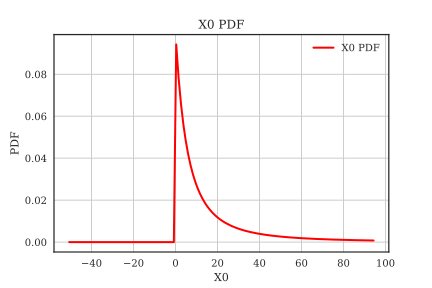

In [5]:
marginal.drawPDF()

In [ ]:
%%time
n = 300000
n_theta = 2000
grid_type = 'lhs'
grid_results_lhs = q_estimate.gridsearch(n_theta, n, grid_type=grid_type, 
                                         keep_input_samples=False, use_sto_func=True)

Time taken: 8.32
Creating grid
Time taken: 111.88
Converting to kendall parameters
Time taken: 150.78
Sample evaluation
Time taken: 155.68
Iteration 0
Time taken: 1003.29
Iteration 200
Time taken: 1832.75
Iteration 400
Time taken: 2676.57
Iteration 600
Time taken: 3531.73
Iteration 800


/home/D58174/anaconda/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in (function (N, RVM, U = NULL)  : Interrupted

  warnings.warn(x, RRuntimeWarning)


KeyboardInterrupt: 

In [ ]:
%%time
grid_type = 'vertices'
grid_results_vertices = q_estimate.gridsearch(n_theta, n, grid_type=grid_type,
                                              keep_input_samples=False, use_sto_func=True)

Time taken: 3574.75
Creating grid


In [ ]:
alpha = 0.5
q_func = quantile_func(alpha)

In [8]:
indep_result = q_estimate.independence(n_input_sample=n)
indep_result.q_func = q_func

In [9]:
n_boot = 200
ci_prob = [0.025, 0.975]
indep_result.q_func = q_func
indep_result.compute_bootstrap(n_boot)
indep_boot_ci = indep_result.compute_quantity_bootstrap_ci(ci_prob)
indep_boot_mean = indep_result.boot_mean
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (indep_boot_mean, indep_result.boot_cov*100.))

Quantile at independence: -115.08 with a C.O.V at 0.2 %


In [10]:
grid_results_lhs.q_func = q_func
grid_results_vertices.q_func = q_func

quantities = grid_results_lhs.quantities
kendalls = grid_results_lhs.kendalls
min_result_grid = grid_results_lhs.min_result
min_kendall = min_result_grid.kendall_tau
min_quant = min_result_grid.quantity

min_result_vertices = grid_results_vertices.min_result
min_kendall_vertices = min_result_vertices.kendall_tau
min_quant_vertices = min_result_vertices.quantity

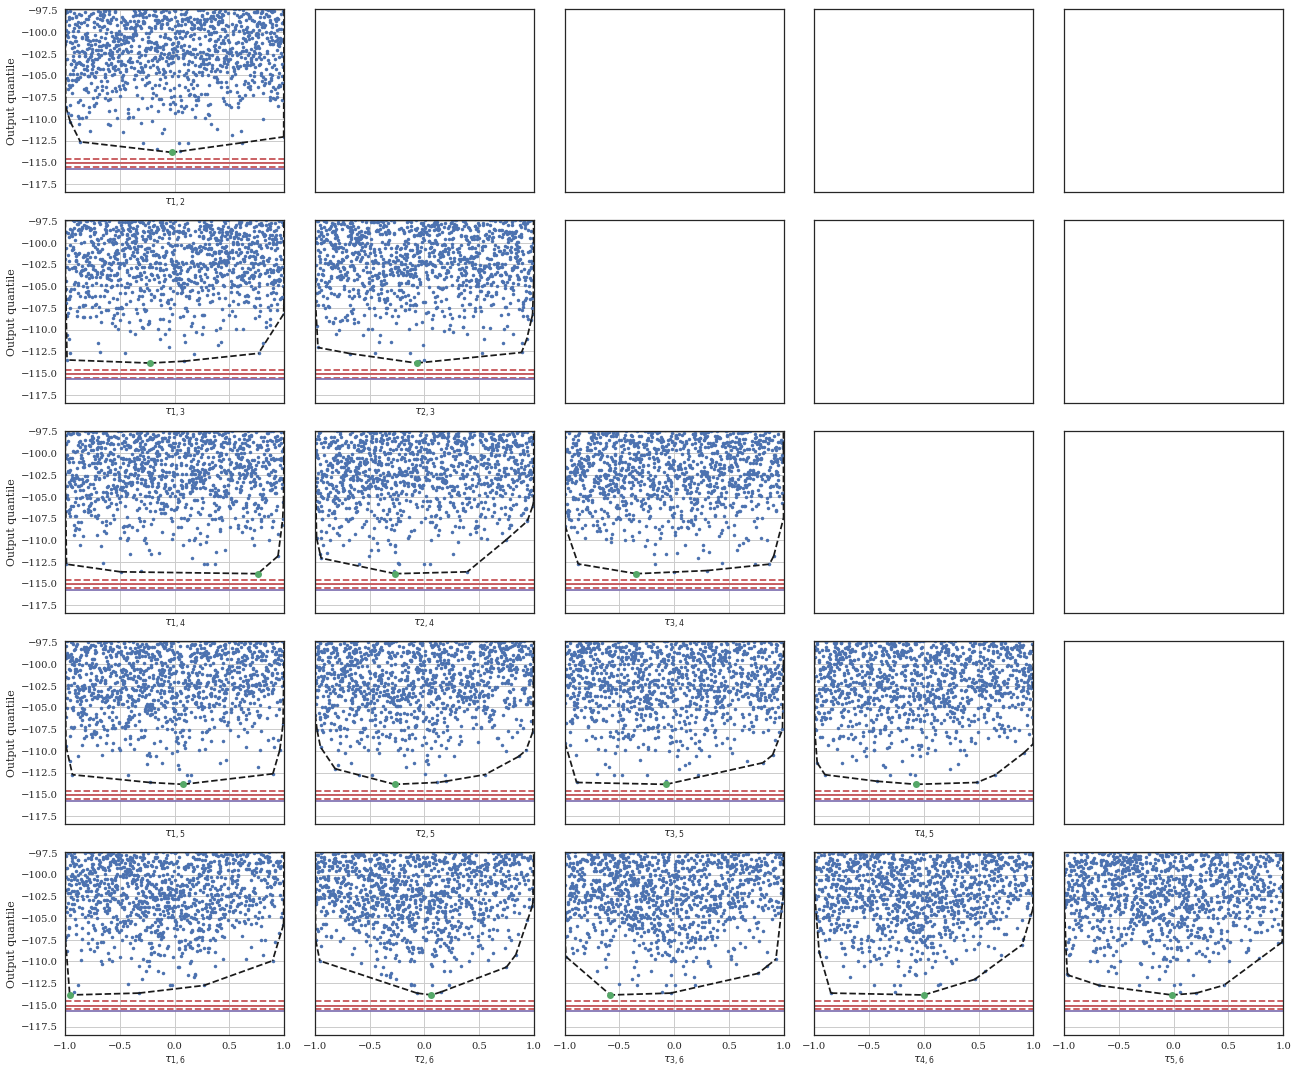

In [11]:
with_perfect = False
with_vertices = True
middle_quant = quantities.mean()
fig, axes = plt.subplots(dim-1, dim-1, figsize=(3*dim, 2.5*dim), sharex=True, sharey=True)
k = 0
n_pairs = int(dim * (dim-1)/2)
for i in range(dim-1):
    for j in range(i+1):
        if dim == 2:
            ax = axes
        else:
            ax = axes[i, j]
        kendalls_k = kendalls[:, k]
        theta_min, theta_max = kendalls.min(), kendalls.max()
        ax.plot(kendalls_k, quantities, '.')
        points = np.asarray([kendalls_k, quantities]).T
        hull = ConvexHull(points, True)
        for simplex in hull.simplices:
            if points[simplex, 1].min() < middle_quant:
                ax.plot(points[simplex, 0], points[simplex, 1], 'k--')
        ax.plot(min_kendall[k], min_quant, 'o')
        ax.plot([theta_min, theta_max], [indep_boot_mean]*2, 'r')
        ax.plot([theta_min, theta_max], [indep_boot_ci[0]]*2, '--r')
        ax.plot([theta_min, theta_max], [indep_boot_ci[1]]*2, '--r')
        
        if with_perfect:
            others = list(range(n_pairs))
            others.remove(k)
            for kk in others:
                id_countermono = kendalls[:, kk] <= -0.99
                id_countmono = kendalls[:, kk] >= 0.99
                ax.plot(params[id_countermono], quantities[id_countermono], 'o', label='')
                ax.plot(params[id_countmono], quantities[id_countmono], 'o', label='')
                
        ax.set_ylim(None, middle_quant)
        ax.set_xlim(theta_min, theta_max)
        if with_vertices:
            ax.plot([-1, 1], [min_quant_vertices]*2, 'm-', label='')
            ax.set_xlim(-1, 1.)
        ax.set_xlabel('$\\tau_{%d, %d}$' % (j+1, i+2))
        ax.grid()
        
        if j == 0:
            ax.set_ylabel('Output quantile')
            
        k += 1
        
fig.tight_layout()
fig.savefig('./output/sec3_example_pitfalls_pareto_%.2f_%.2f_n_%d_ntheta_%d_d_%d_alpha_%d.pdf' % (marginal_params[0], marginal_params[1], n, n_theta, dim, alpha*100))

In [12]:
min_result_grid.compute_bootstrap(n_boot)
grid_boot_ci = min_result_grid.compute_quantity_bootstrap_ci(ci_prob)
print('Min quantile for grid-search: %.2f with a C.O.V at %.1f %%' % (min_result_grid.boot_mean, min_result_grid.boot_cov*100.))

Min quantile for grid-search: -113.86 with a C.O.V at 0.2 %
